In [1]:
# # Load saved model weights
# model.load_state_dict(torch.load('checkpoints\\digit_classifier_no_zeros_18.pth'))

In [5]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Linear-5                  [-1, 128]         131,200
            Linear-6                   [-1, 10]           1,290
Total params: 184,586
Trainable params: 184,586
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.70
Estimated Total Size (MB): 0.92
----------------------------------------------------------------


In [4]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
%matplotlib inline

class RandomPad:
    def __init__(self, fill=1, padding_mode='constant', min_pad=0, max_pad=4):
        self.fill = fill
        self.padding_mode = padding_mode
        self.min_pad = min_pad
        self.max_pad = max_pad

    def __call__(self, img):
        pad_top = torch.randint(self.min_pad, self.max_pad + 1, size=(1,)).item()
        pad_bottom = torch.randint(self.min_pad, self.max_pad + 1, size=(1,)).item()
        pad_left = torch.randint(self.min_pad, self.max_pad + 1, size=(1,)).item()
        pad_right = torch.randint(self.min_pad, self.max_pad + 1, size=(1,)).item()

        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=self.fill, padding_mode=self.padding_mode)

class Threshold(object):
  def __call__(self, x):
    return (x > 0).to(x.dtype)  # do not change the data type
  
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
batch_size = 64
learning_rate = 0.01
num_epochs = 22

# Define a function to add random white pixels or lines
def add_random_white_pixels_or_lines(x, num_pixels, num_lines):
    height, width = x.shape[-2], x.shape[-1]
    indices = torch.randperm(height * width)[:num_pixels]
    x_flattened = x.view(-1, height * width)
    x_flattened[:, indices] = 1.0

    x = x_flattened.view(-1, height, width)

    for i in range(num_lines):
        line_type = random.choice(['horizontal', 'vertical'])
        line_width = random.randint(1, 2)

        if line_type == 'horizontal':
            line_pos = random.randint(0, height - line_width)
            x[line_pos:(line_pos+line_width), :] = 1.0
        else:
            line_pos = random.randint(0, width - line_width)
            x[:, line_pos:(line_pos+line_width)] = 1.0

    return x

def threshold(x, threshold_val):
    x[x >= threshold_val] = 1.0
    x[x < threshold_val] = 0.0
    return x

# Define neural network model
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 1024)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate neural network model and move to device
model = DigitClassifier().to(device)

# # Load saved model weights
# model.load_state_dict(torch.load('digit_classifier_no_zeros_19.pth'))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define data augmentation transformations
transform = transforms.Compose([
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.RandomApply([transforms.RandomRotation(degrees=30)], p=0.1),
    transforms.RandomApply([transforms.RandomCrop(size=(26, 26), padding=1, pad_if_needed=True)], p=0.1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_random_white_pixels_or_lines(x, num_pixels= 150, num_lines=random.randint(0,3))), # Add 15 random white pixels
    transforms.Resize((28, 28)),
    transforms.Normalize((0), (1)),
    transforms.Lambda(lambda x: threshold(x, threshold_val=0.5)),
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='data/',
                            train=True,
                            transform=transform,
                            download=True)
test_dataset = datasets.MNIST(root='data/',
                            train=False,
                            transform=transform,
                            download=True)

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)

# Train model
for epoch in range(num_epochs):

    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # discard zeros
        images = images[labels != 0]
        labels = labels[labels != 0]
        
        images = images.to(device)
        # print(images[0].squeeze())
        # plt.imshow(images[0].squeeze(), cmap='gray')
        # plt.show()
        # break
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every 100 batches
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            images = images[labels != 0]
            
            labels = labels.to(device)
            labels = labels[labels != 0]

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the model on the test images: {:.2f}%'.format(100 * correct / total))
    torch.save(model.state_dict(), f'digit_classifier_very_noisy_{epoch}.pth')

SyntaxError: 'break' outside loop (4108963440.py, line 85)

In [33]:
model.load_state_dict(torch.load('digit_classifier_progressive_noise_21.pth'))

<All keys matched successfully>

In [ ]:
def cv_imshow(img, ax=None):
    gray = False
    
    if len(img.shape) == 2:
        gray = True
    if img.shape == 3 and img.shape[-1] == 1:
        gray = True
    
    if ax is None:
        _, ax = plt.subplots()

    ax.axis("off")
    if gray:
        ax.imshow(img, cmap="gray")
    else:
        ax.imshow(img[:, :, ::-1])

c:\Users\vitor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[[1053   37    1    1    4    6    9   24    0]
 [   6  970    7    2    2    7   18   19    1]
 [   2   33  925    2   21    0   10   15    2]
 [   6   32    0  873    1    8   11   24   27]
 [   1   24   14    1  801   17    4   21    9]
 [   5   27    0    8    7  900    2    7    2]
 [  12   45    3    7    5    0  926   15   15]
 [   0   35   10    2    6   12    4  902    3]
 [   5   31    4   11    5   11   24   33  885]]


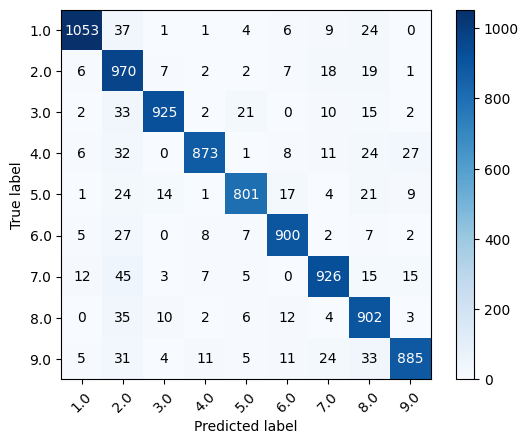

Accuracy of the model on the test images: 91.30%


In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Test model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = np.array([])
    all_predicted = np.array([])
    for images, labels in test_loader:
        images = images.to(device)
        images = images[labels != 0]
        
        labels = labels.to(device)
        labels = labels[labels != 0]
        
        outputs = model(images)
        all_labels = np.append(all_labels, labels)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted = np.append(all_predicted, predicted.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Generate example data
    y_true = all_labels
    y_pred = all_predicted

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print(cm)

    # Plot confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set ticks and tick labels
    ax.set_xticks(np.arange(len(np.unique(y_true))))
    ax.set_yticks(np.arange(len(np.unique(y_true))))
    ax.set_xticklabels(np.unique(y_true))
    ax.set_yticklabels(np.unique(y_true))
    ax.tick_params(axis='x', labelrotation=45)

    # Add annotations
    thresh = cm.max() / 2.0
    for i in range(len(np.unique(y_true))):
        for j in range(len(np.unique(y_true))):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Set labels
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    # Show plot
    plt.show()

    print('Accuracy of the model on the test images: {:.2f}%'.format(100 * correct / total))

[[1091    4   26    3    0    0    9    2    0]
 [   4  974   33    3    1    1   14    0    2]
 [   2   10  978    0   11    0    3    2    4]
 [   3    5   31  908    0    4    6    3   22]
 [   1    2   30    1  838   10    1    7    2]
 [   1    1   27    4    7  914    0    4    0]
 [  12   12   31    6    2    1  946    1   17]
 [   2    6   28    5    7    4    2  903   17]
 [   4    3   28   21    5    3   11    3  931]]


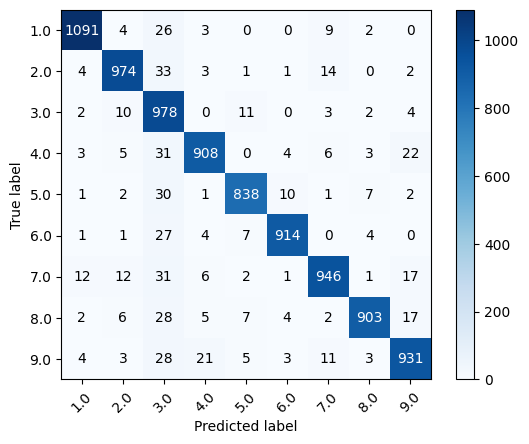

Accuracy of the model on the test images: 94.05%


In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Test model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = np.array([])
    all_predicted = np.array([])
    for images, labels in test_loader:
        images = images.to(device)
        images = images[labels != 0]
        
        labels = labels.to(device)
        labels = labels[labels != 0]
        
        outputs = model(images)
        all_labels = np.append(all_labels, labels)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted = np.append(all_predicted, predicted.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Generate example data
    y_true = all_labels
    y_pred = all_predicted

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print(cm)

    # Plot confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set ticks and tick labels
    ax.set_xticks(np.arange(len(np.unique(y_true))))
    ax.set_yticks(np.arange(len(np.unique(y_true))))
    ax.set_xticklabels(np.unique(y_true))
    ax.set_yticklabels(np.unique(y_true))
    ax.tick_params(axis='x', labelrotation=45)

    # Add annotations
    thresh = cm.max() / 2.0
    for i in range(len(np.unique(y_true))):
        for j in range(len(np.unique(y_true))):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Set labels
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    # Show plot
    plt.show()

    print('Accuracy of the model on the test images: {:.2f}%'.format(100 * correct / total))